# Imports

In [50]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import cv2
import tkinter as tk
from tkinter import filedialog, messagebox

# Directories

In [51]:
color_data_dir = "../data/colorData"
number_data_dir = "../data/numberData"
special_card_data_dir = "../data/specialCardData"
preprocessed_data_dir = "../data/preprocessedData"

# Preprocessing

In [52]:
def preprocess_and_save_images(directory, target_size=(300, 300)):
    images = []
    labels = []

    if os.path.isdir(directory):
        for label in os.listdir(directory):
            class_dir = os.path.join(directory, label)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    try:
                        img = Image.open(img_path).convert('RGB')
                        img = img.resize(target_size)
                        img_array = np.array(img, dtype=np.float32) / 255.0

                        images.append(img_array)
                        labels.append(label)
                    except Exception as e:
                        print(f"Error processing image {img_path}: {e}")

    # Encode labels as integers
    unique_labels = np.unique(labels)
    label_dict = {label: index for index, label in enumerate(unique_labels)}
    labels_encoded = np.array([label_dict[label] for label in labels], dtype=np.int64)

    return np.array(images, dtype=np.float32), labels_encoded, unique_labels


Preprocessing Images and Data Labels

In [53]:
color_images, color_labels, unique_color_labels = preprocess_and_save_images(color_data_dir)
number_images, number_labels, unique_number_labels = preprocess_and_save_images(number_data_dir)
special_card_images, special_card_labels, unique_special_labels = preprocess_and_save_images(special_card_data_dir)

Combining Images and Labels

In [54]:
all_images = np.concatenate([color_images, number_images, special_card_images], axis=0)
all_color_labels = np.concatenate([color_labels, np.full(len(number_labels), -1), np.full(len(special_card_labels), -1)])
all_number_labels = np.concatenate([np.full(len(color_labels), -1), number_labels, np.full(len(special_card_labels), -1)])
all_special_labels = np.concatenate([np.full(len(color_labels), -1), np.full(len(number_labels), -1), special_card_labels])

Ensure that all images and labels have the same length

In [55]:
assert len(all_images) == len(all_color_labels) == len(all_number_labels) == len(all_special_labels), "Data lengths do not match!"

# Train / Test Split

In [56]:
X_train, X_test, y_train_color, y_test_color, y_train_number, y_test_number, y_train_special, y_test_special = train_test_split(
    all_images, all_color_labels, all_number_labels, all_special_labels, test_size=0.2, random_state=42
)

# Creating Datasets

In [57]:
def create_dataset(images, color_labels, number_labels, special_labels, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices(
        (images, {"color_output": color_labels, "number_output": number_labels, "special_output": special_labels})
    )
    dataset = dataset.shuffle(len(images)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

Creating Training and Validation Datasets

In [58]:
train_dataset = create_dataset(X_train, y_train_color, y_train_number, y_train_special)
test_dataset = create_dataset(X_test, y_test_color, y_test_number, y_test_special)

Custom Loss function to handle -1 labels

In [59]:
def custom_loss(y_true, y_pred):
    mask = tf.not_equal(y_true, -1)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    
    return tf.keras.losses.sparse_categorical_crossentropy(y_true_masked, y_pred_masked)

# Building the Model

In [60]:
input_layer = Input(shape=(300, 300, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

Output Layers

In [61]:
color_output = Dense(len(unique_color_labels), activation='softmax', name='color_output')(x)
number_output = Dense(len(unique_number_labels), activation='softmax', name='number_output')(x)
special_output = Dense(len(unique_special_labels), activation='softmax', name='special_output')(x)

# Defining, Compiling and Training Model

In [62]:
model = Model(inputs=input_layer, outputs=[color_output, number_output, special_output])

Compiling the model with the custom loss function

In [63]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'color_output': custom_loss,
                    'number_output': custom_loss,
                    'special_output': custom_loss},
              metrics={'color_output': 'accuracy',
                       'number_output': 'accuracy',
                       'special_output': 'accuracy'})

Training the Model

In [64]:
history = model.fit(train_dataset, epochs=30, validation_data=test_dataset)

Epoch 1/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 119s 735ms/step - color_output_accuracy: 0.2288 - color_output_loss: 1.4791 - loss: nan - number_output_accuracy: 0.0336 - number_output_loss: 2.9900 - special_output_accuracy: 0.0585 - special_output_loss: nan - val_color_output_accuracy: 0.4459 - val_color_output_loss: 0.2656 - val_loss: nan - val_number_output_accuracy: 0.0295 - val_number_output_loss: nan - val_special_output_accuracy: 0.1098 - val_special_output_loss: nan
Epoch 2/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 60s 392ms/step - color_output_accuracy: 0.4292 - color_output_loss: 0.1381 - loss: nan - number_output_accuracy: 0.0507 - number_output_loss: 2.8329 - special_output_accuracy: 0.1069 - special_output_loss: nan - val_color_output_accuracy: 0.4639 - val_color_output_loss: nan - val_loss: nan - val_number_output_accuracy: 0.0590 - val_number_output_loss: 2.5923 - val_special_output_accuracy: 0.1049 - val_special_output_loss: nan
Epoch 3/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 66s 429ms/step - co

# Model Metrics

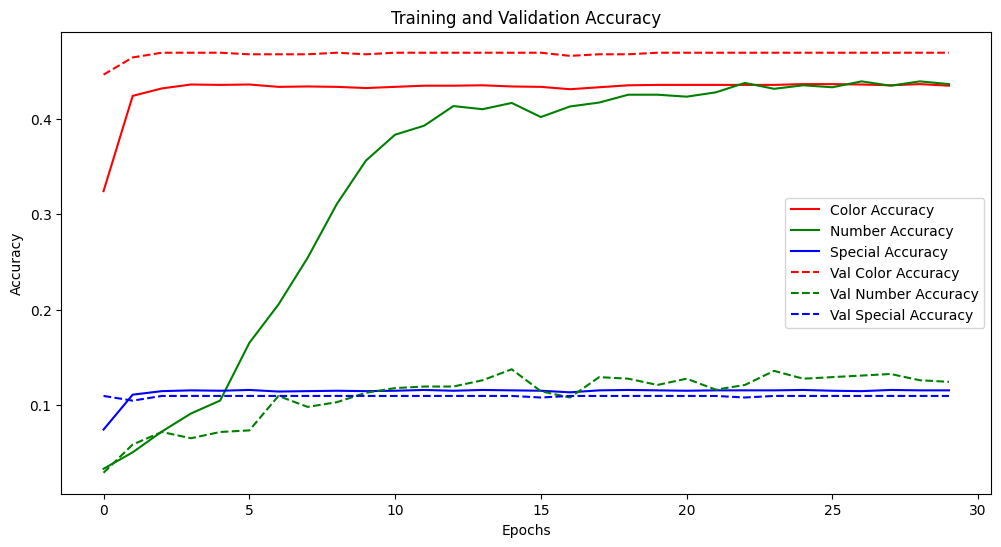

In [65]:
color_accuracy = history.history['color_output_accuracy']
number_accuracy = history.history['number_output_accuracy']
special_accuracy = history.history['special_output_accuracy']
val_color_accuracy = history.history['val_color_output_accuracy']
val_number_accuracy = history.history['val_number_output_accuracy']
val_special_accuracy = history.history['val_special_output_accuracy']

epochs = range(len(color_accuracy))

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, color_accuracy, 'r', label='Color Accuracy')
plt.plot(epochs, number_accuracy, 'g', label='Number Accuracy')
plt.plot(epochs, special_accuracy, 'b', label='Special Accuracy')
plt.plot(epochs, val_color_accuracy, 'r--', label='Val Color Accuracy')
plt.plot(epochs, val_number_accuracy, 'g--', label='Val Number Accuracy')
plt.plot(epochs, val_special_accuracy, 'b--', label='Val Special Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Prediction Functions
Predicting with a File Path

In [66]:
def predict_uno_card(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((300, 300))

    # plt.imshow(img)
    # plt.title("Resized Image")
    # plt.axis('off')
    # plt.show()

    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    color_prediction, number_prediction, special_prediction = model.predict(img_array)
    color_label = unique_color_labels[np.argmax(color_prediction)]
    number_label = unique_number_labels[np.argmax(number_prediction)]
    special_label = unique_special_labels[np.argmax(special_prediction)]

    # print(f"Predicted color: {color_label}")
    # print(f"Predicted number: {number_label}")
    # print(f"Is special card: {special_label}")

    return f"Predicted color: {color_label}\nPredicted number: {number_label}\nIs special card: {special_label}"

Predicting with an image

In [67]:
def predict_uno_card_with_img(img):
    img = img.resize((300, 300))
    img = img.convert('RGB')

    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    color_prediction, number_prediction, special_prediction = model.predict(img_array)
    color_label = unique_color_labels[np.argmax(color_prediction)]
    number_label = unique_number_labels[np.argmax(number_prediction)]
    special_label = unique_special_labels[np.argmax(special_prediction)]

    return f"{color_label}{number_label} Special:{special_label}"

# GUI
Function to upload an Image from the computer

In [68]:
def upload_image(main_window):
    try:
        # Open the file dialog to select an image
        file_path = filedialog.askopenfilename(
            title="Select an Image",
            filetypes=[("Image Files", "*.png;*.jpg;*.jpeg;*.gif;*.bmp")]
        )
        
        # If no file is selected (cancel button is clicked)
        if not file_path:
            messagebox.showinfo("No file selected", "You did not select an image.")
            return

        # Try to open the image using Pillow
        try:
            image = Image.open(file_path)

            # Call your existing predict_uno_card function
            prediction = predict_uno_card(file_path)
            
            # Show the result in a separate small window (new tkinter window)
            result_window = tk.Toplevel(main_window)
            result_window.title("Prediction Result")
            result_label = tk.Label(result_window, text=prediction, font=("Arial", 12))
            result_label.pack(padx=20, pady=20)
            result_button = tk.Button(result_window, text="Close", command=result_window.destroy)
            result_button.pack(pady=10)

            result_window.geometry("300x150")  # Set a small window size for the result

        except Exception as e:
            messagebox.showerror("Error", f"An error occurred while opening the image: {e}")
        
    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {e}")

Function to Start the Livestream for Live Detection

In [69]:
def start_livestream():
    cap = cv2.VideoCapture(0)
    
    # Create a new window for edge detection
    edge_window = cv2.namedWindow("Edge Detection")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        height, width, _ = frame.shape
        start_x = width // 4
        start_y = height // 4
        end_x = 3 * width // 4
        end_y = 3 * height // 4

        square_frame = frame[start_y:end_y, start_x:end_x]

        # Convert from BGR to RGB
        input_image = cv2.cvtColor(square_frame, cv2.COLOR_BGR2RGB)

        # Convert the frame to a PIL Image object
        input_image = Image.fromarray(input_image)

        prediction = predict_uno_card_with_img(input_image)

        # Draw bounding box and label
        cv2.rectangle(frame, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
        cv2.putText(frame, f'{prediction}', (start_x, start_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Show the original video feed with bounding box
        cv2.imshow('Video Feed', frame)
        
        # Apply edge detection to the marked area and display it in a new window
        gray = cv2.cvtColor(square_frame, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        cv2.imshow("Edge Detection", edges)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

Starting the GUI using Tkinter, and Binding the Functions to the buttons

In [70]:
# Create the main window
root = tk.Tk()
root.title("Image and Livestream Prediction")
root.geometry("400x200")  # Set window size

# Create buttons with larger size
upload_button = tk.Button(root, text="Upload Image", command=lambda: upload_image(root), width=20, height=2)
upload_button.pack(pady=20)
livestream_button = tk.Button(root, text="Start Livestream", command=start_livestream, width=20, height=2)
livestream_button.pack(pady=20)

# Run the application
root.mainloop()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━